# CSCA 5632 Assignment #4 - NLP Kaggle BBC News Classification Mini Project
### By Moshiur Howlader
##### Github Link : https://github.com/Mosh333/csca5632-nlp-kaggle-bbc-news-classification

### 1. Introduction

This mini-project involves two parts:
1) Categorizing news article data using an **unsupervised algorithm** called **matrix factorization (NMF)**, followed by A/B testing between matrix factorization and selected **supervised learning algorithms** to compare classification accuracy.
2) Exploring the **limitations of sklearn’s non-negative matrix factorization** implementation using the **movie ratings dataset** (from HW3 – Recommender Systems).

For Part 1, the dataset used is the BBC News Classification dataset, which contains a total of 2,225 articles divided into training (1,490) and testing (735) subsets.
Each article includes a short text passage and a category label drawn from one of five broad news topics: business, entertainment, politics, sport, and tech.

| File                             | Description                                                      | Columns                         |
| -------------------------------- | ---------------------------------------------------------------- | ------------------------------- |
| **BBC News Train.csv**           | Labeled training dataset used for model training and evaluation. | `ArticleId`, `Text`, `Category` |
| **BBC News Test.csv**            | Unlabeled dataset used for generating predictions.               | `ArticleId`, `Text`             |
| **BBC News Sample Solution.csv** | Sample file illustrating the expected Kaggle submission format.  | `ArticleId`, `Category`         |

For Part 2, the data used for exploring the **limitations of sklearn’s non-negative matrix factorization** will have the following data structure:

| File           | Description                                                                                                 | Key Columns                   |
| -------------- | ----------------------------------------------------------------------------------------------------------- | ----------------------------- |
| **train.csv**  | Training subset of user–movie ratings used to fit the matrix-factorization model.                           | `userId`, `movieId`, `rating` |
| **test.csv**   | Test subset containing a portion of user–movie pairs whose ratings are to be predicted.                     | `userId`, `movieId`, `rating` |
| **users.csv**  | Optional metadata providing demographic or profile information about users (e.g., age, gender, occupation). | `userId`, `...`               |
| **movies.csv** | Metadata describing each movie title and its genre(s).                                                      | `movieId`, `title`, `genres`  |


### Part 1 - New Classification

#### 2. Data

In [1]:
import os

# Always start paths relative to the notebook file location
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
DATA_DIR = os.path.join(BASE_DIR, "data")

print("Base directory:", BASE_DIR)
print("Data directory:", DATA_DIR)

Base directory: d:\Documents\GitHub\csca5632-nlp-kaggle-bbc-news-classification
Data directory: d:\Documents\GitHub\csca5632-nlp-kaggle-bbc-news-classification\data


#### 2.1 Extracting word features and Explorator Data Analysis (EDA)

In this section, the BBC News dataset is explored to gain an initial understanding of its structure and content. The exploratory analysis focuses on identifying the distribution of categories, variations in text length, and any potential issues such as imbalance or noise. These insights help shape the approach for data cleaning and feature extraction in the later stages of the project.

##### 2.1.1 Import Libraries and Load the Dataset

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
import re
from nltk.corpus import stopwords

# Download stopwords (first run only)
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Load datasets
train_df = pd.read_csv(os.path.join(DATA_DIR, "BBC News Train.csv"))
test_df = pd.read_csv(os.path.join(DATA_DIR, "BBC News Test.csv"))

# Basic info
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
display(train_df.head())
train_df.info()


Train shape: (1490, 3)
Test shape: (735, 2)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\howla\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.1+ KB


#### 2.1.2 Check for Missing Values and Category Overview

In [3]:
# Check missing values
print("\nMissing values per column:")
print(train_df.isna().sum())

# Unique labels
print("\nUnique Categories:", train_df['Category'].unique())



Missing values per column:
ArticleId    0
Text         0
Category     0
dtype: int64

Unique Categories: ['business' 'tech' 'politics' 'sport' 'entertainment']


#### 2.1.3 Category Distribution Visualization

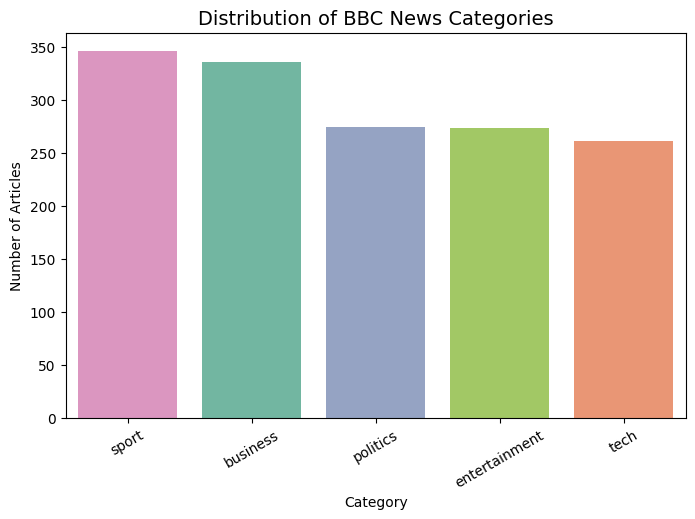

In [4]:
plt.figure(figsize=(8,5))
sns.countplot(
    x='Category',
    data=train_df,
    order=train_df['Category'].value_counts().index,
    hue='Category',
    palette="Set2",
    legend=False
)
plt.title("Distribution of BBC News Categories", fontsize=14)
plt.xlabel("Category")
plt.ylabel("Number of Articles")
plt.xticks(rotation=30)
plt.show()


#### 2.1.4 Article Length Analysis

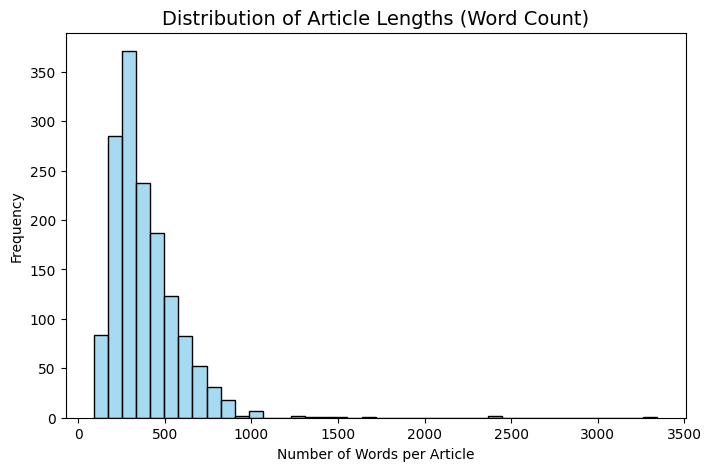


Average word count statistics by category:


,mean,median,std
Category,,,
business,334.17,304.0,133.53
entertainment,333.91,272.0,203.89
politics,449.69,441.5,258.84
sport,335.35,294.5,185.44
tech,501.86,457.0,211.67


In [5]:
train_df['text_length'] = train_df['Text'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(8,5))
sns.histplot(train_df['text_length'], bins=40, color="skyblue")
plt.title("Distribution of Article Lengths (Word Count)", fontsize=14)
plt.xlabel("Number of Words per Article")
plt.ylabel("Frequency")
plt.show()

# Mean and median word count per category
length_stats = train_df.groupby('Category')['text_length'].agg(['mean', 'median', 'std']).round(2)
print("\nAverage word count statistics by category:")
display(length_stats)

#### 2.1.5 Basic Text Cleaning

In [6]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)
    words = [word for word in text.split() if word not in stop_words and len(word) > 2]
    return ' '.join(words)

train_df['clean_text'] = train_df['Text'].apply(clean_text)


#### 2.1.6 Word Frequency Analysis

C:\Users\howla\AppData\Local\Temp\ipykernel_25796\3955227534.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Word', data=common_words, palette="viridis")


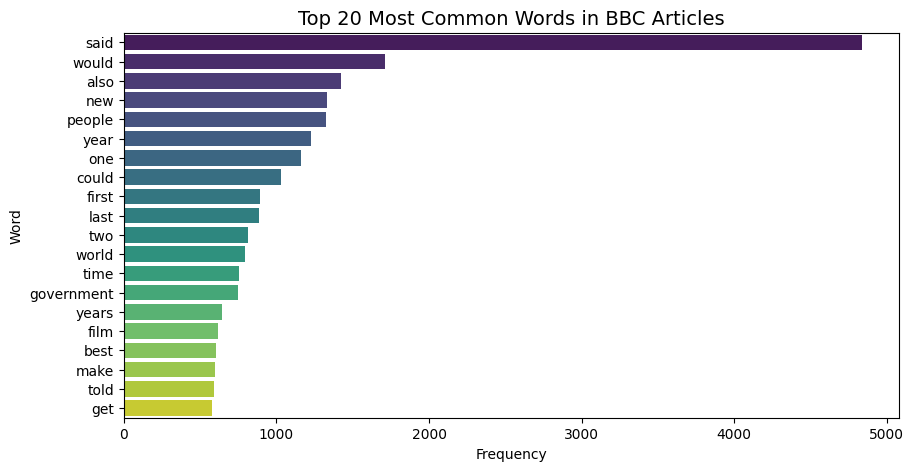

In [7]:
from collections import Counter
all_words = ' '.join(train_df['clean_text']).split()
word_freq = Counter(all_words)
common_words = pd.DataFrame(word_freq.most_common(20), columns=['Word', 'Frequency'])

plt.figure(figsize=(10,5))
sns.barplot(x='Frequency', y='Word', data=common_words, palette="viridis")
plt.title("Top 20 Most Common Words in BBC Articles", fontsize=14)
plt.show()


#### 2.1.7 Word Cloud Visualizations

Top 20 Most Frequent Words:


,Word,Frequency
0,said,4838
1,would,1711
2,also,1426
3,new,1334
4,people,1322
5,year,1228
6,one,1158
7,could,1032
8,first,892
9,last,883


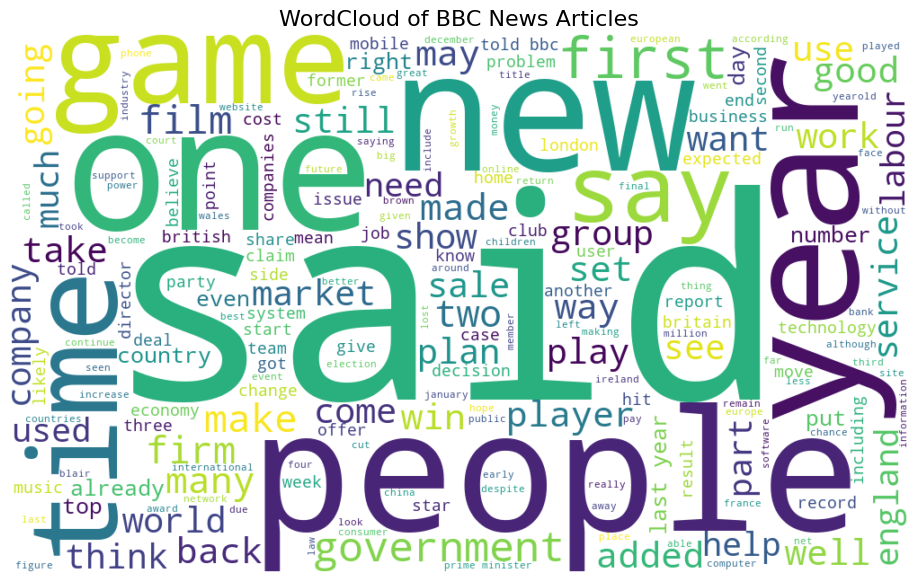

In [13]:
# Overall word cloud
# wordcloud = WordCloud(width=1000, height=600, background_color='white').generate(' '.join(train_df['clean_text']))
# plt.figure(figsize=(12,7))
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.title("WordCloud of BBC News Articles", fontsize=16)
# plt.show()


from collections import Counter

# Combine all cleaned text
all_words = ' '.join(train_df['clean_text']).split()

# Count word frequencies
word_freq = Counter(all_words)

# Convert to DataFrame for display
freq_df = pd.DataFrame(word_freq.items(), columns=['Word', 'Frequency'])
freq_df = freq_df.sort_values(by='Frequency', ascending=False).reset_index(drop=True)

# Display top 20 words in a table
print("Top 20 Most Frequent Words:")
display(freq_df.head(20))

# Visualize word cloud
wordcloud = WordCloud(
    width=1000,
    height=600,
    background_color='white'
).generate(' '.join(train_df['clean_text']))

plt.figure(figsize=(12,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud of BBC News Articles", fontsize=16)
plt.show()


#### 2.1.8 Category-Specific Word Clouds


Top 15 Words in 'business' Category:


,Word,Frequency
0,said,1100
1,year,417
2,would,308
3,also,279
4,market,278
5,new,273
6,firm,261
7,growth,257
8,company,252
9,last,235


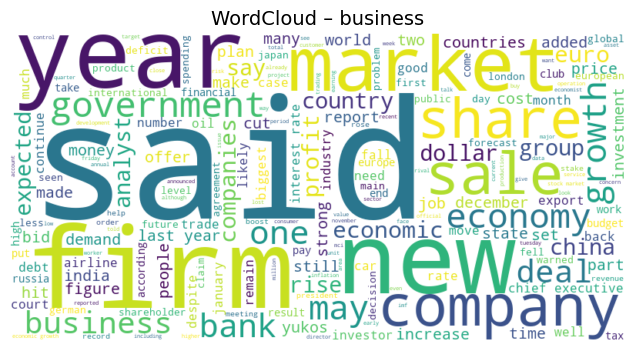


Top 15 Words in 'tech' Category:


,Word,Frequency
0,said,1064
1,people,646
2,new,349
3,also,348
4,one,326
5,mobile,326
6,would,322
7,could,308
8,technology,303
9,users,268


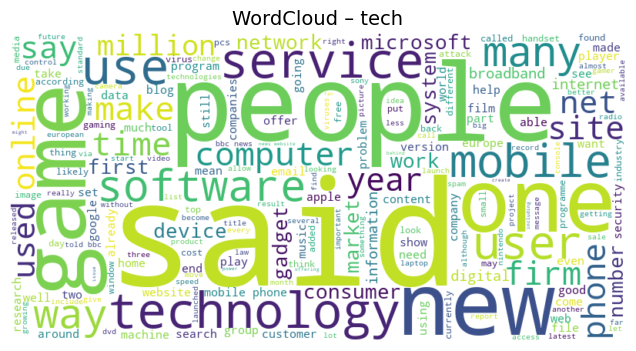


Top 15 Words in 'politics' Category:


,Word,Frequency
0,said,1445
1,would,710
2,labour,488
3,government,462
4,election,396
5,blair,389
6,people,372
7,party,361
8,also,308
9,minister,284


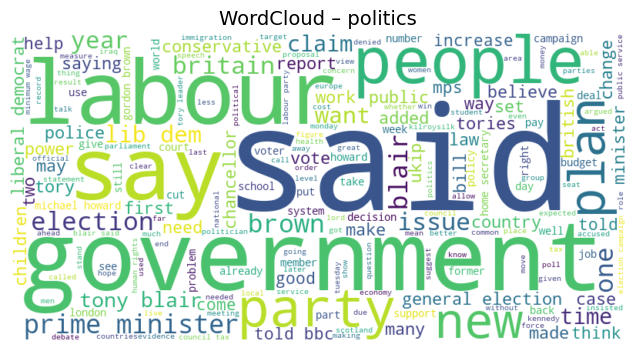


Top 15 Words in 'sport' Category:


,Word,Frequency
0,said,635
1,game,352
2,england,327
3,first,323
4,win,292
5,world,261
6,last,255
7,two,253
8,one,238
9,would,233


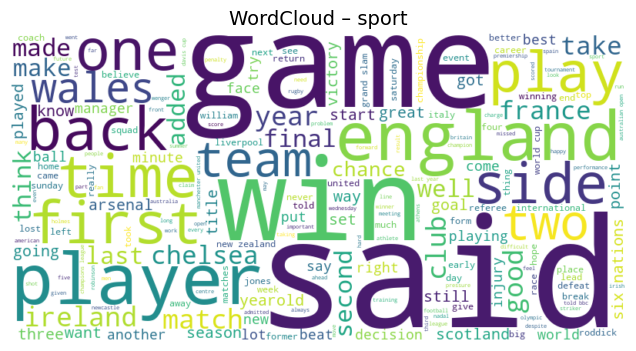


Top 15 Words in 'entertainment' Category:


,Word,Frequency
0,said,594
1,film,553
2,best,404
3,also,277
4,year,263
5,one,258
6,music,255
7,new,234
8,show,220
9,awards,184


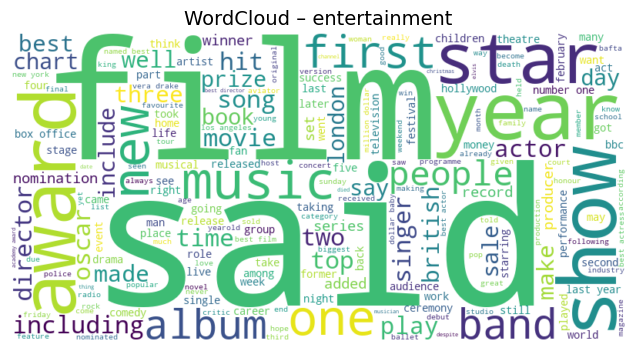

In [14]:
# categories = train_df['Category'].unique()
# for cat in categories:
#     subset = train_df[train_df['Category'] == cat]
#     text = ' '.join(subset['clean_text'])
#     wc = WordCloud(width=800, height=400, background_color='white').generate(text)
#     plt.figure(figsize=(8,4))
#     plt.imshow(wc, interpolation='bilinear')
#     plt.axis('off')
#     plt.title(f"WordCloud - {cat}", fontsize=14)
#     plt.show()

from collections import Counter

categories = train_df['Category'].unique()

for cat in categories:
    # Subset data by category
    subset = train_df[train_df['Category'] == cat]
    text = ' '.join(subset['clean_text']).split()
    
    # Compute word frequency
    word_freq = Counter(text)
    freq_df = pd.DataFrame(word_freq.items(), columns=['Word', 'Frequency'])
    freq_df = freq_df.sort_values(by='Frequency', ascending=False).reset_index(drop=True)
    
    # Display top 15 words in a table
    print(f"\nTop 15 Words in '{cat}' Category:")
    display(freq_df.head(15))
    
    # Generate category-specific WordCloud
    wc = WordCloud(
        width=800,
        height=400,
        background_color='white'
    ).generate(' '.join(text))
    
    plt.figure(figsize=(8,4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud – {cat}", fontsize=14)
    plt.show()



The dataset consists of BBC News articles labeled under different categories such as business, entertainment, politics, sport, and tech.
Each row represents a news article, and each label corresponds to its topic category.
I began by loading and inspecting the training and test datasets to understand their structure and verify the presence of text and label columns.

#### 2.2 TF-IDF feature extraction

Now we move on to processing the raw texts found in our CSV data into feature vectors. As mentioned in the assignment requirement, there are many options (TF-IDF, GloVe, Word2Vec) for converting text into a numerical format that machine learning models can interpret.

For this project, I chose TF-IDF (Term Frequency–Inverse Document Frequency) because it is simple, efficient, and well-suited for linear models such as Non-Negative Matrix Factorization (NMF), which will be used later in this analysis. TF-IDF assigns each word a weight based on how frequently it appears in a document relative to how common it is across the entire corpus. Words that appear often in one article but rarely across others—such as “government”, “market”, or “football”—receive higher importance scores, while common filler words like “the”, “is”, and “said” are given lower weights.

This transformation converts the corpus of news articles into a sparse numerical matrix, where each row corresponds to an article and each column represents a unique word feature. The resulting feature matrix provides a quantitative representation of text data that can now be used for both unsupervised topic discovery (via NMF) and supervised text classification models.

While advanced embedding methods such as Word2Vec and GloVe can capture semantic relationships between words, they require larger datasets and more complex preprocessing. In contrast, TF-IDF provides a transparent and interpretable representation that is ideal for the scale and objectives of this mini-project.

More details regarding the various text data vectorization can be found either via Googling or seeing some references below:

- https://en.wikipedia.org/wiki/Tf%E2%80%93idf
- https://en.wikipedia.org/wiki/GloVe
- https://en.wikipedia.org/wiki/Word2vec
- https://www.geeksforgeeks.org/machine-learning/understanding-tf-idf-term-frequency-inverse-document-frequency/
- https://blog.nashtechglobal.com/text-data-vectorization-techniques-in-natural-language-processing/
- https://www.deepset.ai/blog/what-is-text-vectorization-in-nlp

In [11]:
# Convert cleaned text into numerical TF-IDF vectors

from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,       # limit to top 5000 most important words
    min_df=5,                # ignore very rare words
    max_df=0.7,              # ignore very common words
    stop_words='english'     # remove common English stopwords
)

# Fit on training data and transform both train + test
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df['clean_text'])
X_test_tfidf = tfidf_vectorizer.transform(test_df['Text'].apply(str.lower))

# Store feature names for inspection
feature_names = tfidf_vectorizer.get_feature_names_out()

print("TF-IDF matrix shape (train):", X_train_tfidf.shape)
print("TF-IDF matrix shape (test):", X_test_tfidf.shape)

TF-IDF matrix shape (train): (1490, 5000)
TF-IDF matrix shape (test): (735, 5000)


### Building and training models

In [12]:
# Unsupervised Topic Modeling using NMF
from sklearn.decomposition import NMF
import numpy as np
import pandas as pd

# Choose number of components (topics)
n_topics = 5  # since we know there are 5 BBC news categories
nmf_model = NMF(n_components=n_topics, random_state=42)

# Fit the model on the training TF-IDF data
W_train = nmf_model.fit_transform(X_train_tfidf)  # document-topic matrix
H = nmf_model.components_                        # topic-word matrix

print("NMF model trained successfully!")
print("W_train shape:", W_train.shape)
print("H shape:", H.shape)

# Inspect top words per topic
n_top_words = 10
feature_names = tfidf_vectorizer.get_feature_names_out()

for topic_idx, topic in enumerate(H):
    top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
    print(f"\nTopic #{topic_idx + 1}: {' | '.join(top_words)}")


# Get the dominant topic for each article
train_topic_indices = np.argmax(W_train, axis=1)

# Create a DataFrame to compare real labels vs. dominant topic
topic_df = pd.DataFrame({
    'True_Category': train_df['Category'],
    'Dominant_Topic': train_topic_indices
})

# Show sample mapping
topic_df.head(10)

topic_category_map = (
    topic_df.groupby('Dominant_Topic')['True_Category']
    .agg(lambda x: x.value_counts().index[0])
)
print(topic_category_map)

# Transform the test TF-IDF data into the topic space
W_test = nmf_model.transform(X_test_tfidf)

# Get the dominant topic for each test article
test_topic_indices = np.argmax(W_test, axis=1)

# Map topics to predicted category labels
y_test_pred = [topic_category_map[t] for t in test_topic_indices]


# Create a submission DataFrame
submission = pd.DataFrame({
    'ArticleId': test_df['ArticleId'],
    'Category': y_test_pred
})

# Preview first few rows
submission.head()

submission.to_csv('submission.csv', index=False)
print("✅ submission.csv file created successfully!")



NMF model trained successfully!
W_train shape: (1490, 5)
H shape: (5, 5000)

Topic #1: england | game | win | wales | ireland | cup | players | team | play | france

Topic #2: labour | election | blair | brown | party | government | minister | howard | tax | prime

Topic #3: mobile | people | music | phone | technology | digital | users | phones | software | broadband

Topic #4: film | best | awards | award | actor | actress | films | festival | director | oscar

Topic #5: growth | economy | year | bank | sales | market | economic | oil | china | shares
Dominant_Topic
0            sport
1         politics
2             tech
3    entertainment
4         business
Name: True_Category, dtype: object
✅ submission.csv file created successfully!


### Part 2